In [1]:
!pip install yahoo_fin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 8.6 MB/s eta 0:00:00
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1257 sha256=59fde497afac77f68b5283d4f935582755fb370d153de9ca9812e9466e2f179d
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24570 sha256=5c90cdea7082ffdacd80ad1e5ae556c1476a2cdfb2d138da8188a48655e0f28a
  Stored in directory: /root/.cache/pip/wheels/70/4b/f0/ea

In [2]:
# Import libraries 
import numpy as np
import pandas as pd
import time as tm
import datetime as dt
import tensorflow as tf

from yahoo_fin import stock_info as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers import Activation
from keras.layers import Bidirectional

# Graphics library
import matplotlib.pyplot as plt

In [3]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, GS
STOCK = 'GS'

# Current date
date_now = tm.strftime('2023-06-01')
date_4_years_back = tm.strftime('2019-01-01')

In [4]:
# LOAD DATA 
# from yahoo_fin 
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK, 
    start_date=date_4_years_back, 
    end_date=date_now, 
    interval='1d')

In [5]:
# Display data loaded in the DataFrame
init_df

,open,high,low,close,adjclose,volume,ticker
2019-01-02,164.330002,172.250000,163.350006,172.029999,155.290863,3999400,GS
2019-01-03,170.660004,171.770004,168.289993,169.509995,153.016083,4060200,GS
2019-01-04,172.990005,176.000000,171.100006,175.050003,158.017044,3788300,GS
2019-01-07,175.229996,177.830002,172.270004,176.020004,158.892624,3152100,GS
2019-01-08,177.779999,178.100006,172.899994,175.369995,158.305878,2692700,GS
...,...,...,...,...,...,...,...
2023-05-24,320.390015,321.899994,318.799988,319.809998,317.393280,1439100,GS
2023-05-25,318.920013,325.179993,318.799988,323.880005,321.432526,1618500,GS
2023-05-26,324.720001,332.869995,324.000000,332.010010,329.501099,2718700,GS
2023-05-30,332.079987,332.529999,327.730011,330.829987,328.329987,1998600,GS


In [6]:
# remove columns which our neural network will not use
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index

In [7]:
# check the updated data frame
init_df

# save a copy of the original close prices to be used later
saved_df = init_df.copy()

In [9]:
# Read the CSV file into a DataFrame
dff_df = pd.read_csv("/DFF.csv")

print(dff_df)

            DATE   DFF
0     2020-05-26  0.05
1     2020-05-27  0.05
2     2020-05-28  0.05
3     2020-05-29  0.05
4     2020-05-30  0.05
...          ...   ...
1096  2023-05-27  5.08
1097  2023-05-28  5.08
1098  2023-05-29  5.08
1099  2023-05-30  5.08
1100  2023-05-31  5.08

[1101 rows x 2 columns]


In [10]:
# Rename a single column

dff_df = dff_df.rename(columns={'DATE': 'date'})

#Convert data type 

dff_df['date'] = pd.to_datetime(dff_df['date'])

#Check datatype 

dff_df.dtypes


date    datetime64[ns]
DFF            float64
dtype: object

In [11]:
# Join the inflation_df to init_df based on the "date" column
init_2_df = init_df.merge(dff_df, on='date')

# Print the updated DataFrame
print(init_2_df)

          close       date   DFF
0    196.059998 2020-05-26  0.05
1    209.660004 2020-05-27  0.05
2    201.220001 2020-05-28  0.05
3    196.490005 2020-05-29  0.05
4    199.929993 2020-06-01  0.05
..          ...        ...   ...
755  319.809998 2023-05-24  5.08
756  323.880005 2023-05-25  5.08
757  332.010010 2023-05-26  5.08
758  330.829987 2023-05-30  5.08
759  323.899994 2023-05-31  5.08

[760 rows x 3 columns]


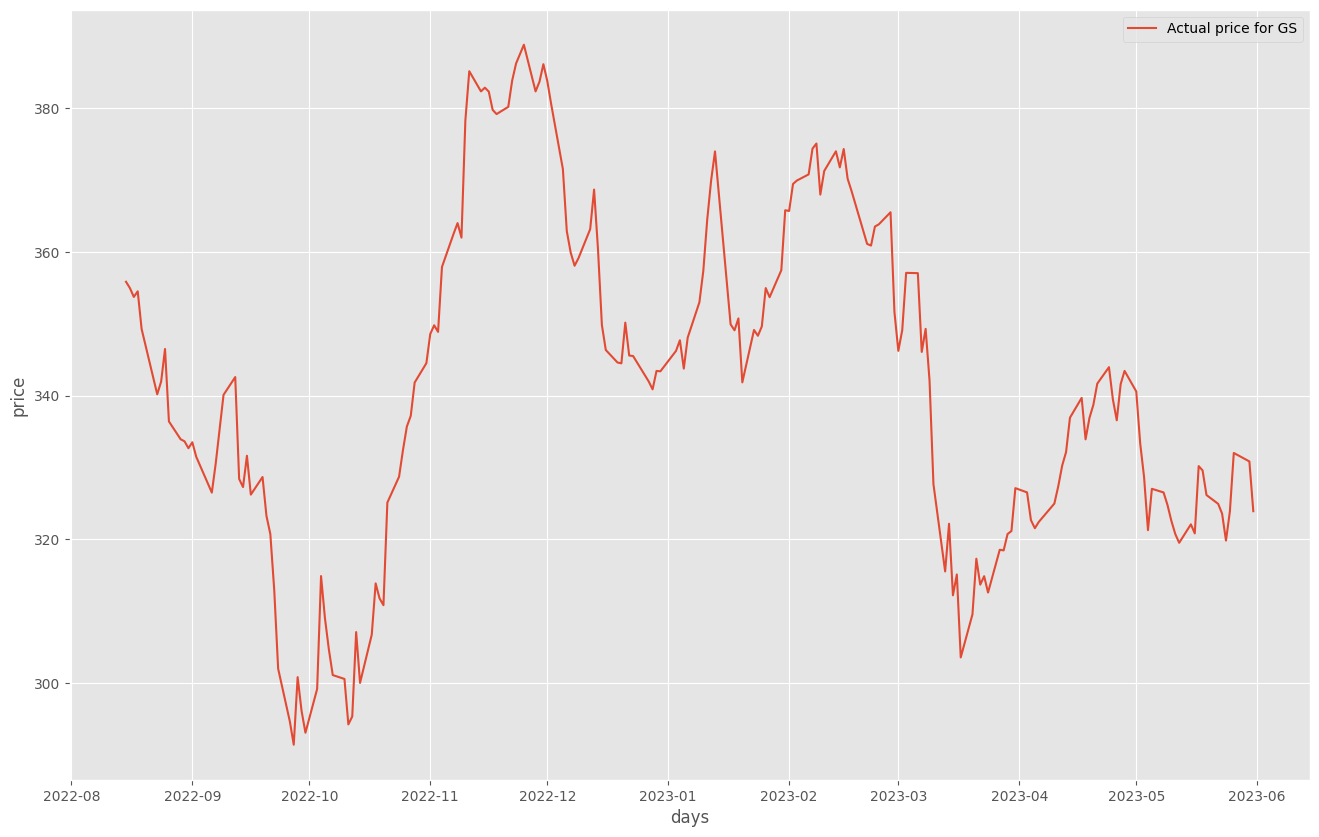

In [12]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [13]:
init_2_df.dtypes

close           float64
date     datetime64[ns]
DFF             float64
dtype: object

In [14]:
# Calculate for outliers

# Calculate the quartiles and interquartile range (IQR)
Q1 = init_2_df['close'].quantile(0.25)
Q3 = init_2_df['close'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper fences
lower_fence = Q1 - 1.5 * IQR
upper_fence = Q3 + 1.5 * IQR

# Identify outliers
outliers = init_2_df[(init_2_df['close'] < lower_fence) | (init_2_df['close'] > upper_fence)]

# Print the outliers
print("Outliers:")
print(outliers)


Outliers:
Empty DataFrame
Columns: [close, date, DFF]
Index: []


In [15]:
from sklearn.preprocessing import StandardScaler
# Scale data for ML engine
scaler_DFF = StandardScaler()
scaler = MinMaxScaler()
init_2_df['close'] = scaler.fit_transform(np.expand_dims(init_2_df['close'].values, axis=1))
init_2_df['DFF'] = scaler_DFF.fit_transform(init_2_df['DFF'].values.reshape(-1, 1))

In [16]:
# check the scaled data
(init_2_df)

,close,date,DFF
0,0.041812,2020-05-26,-0.679459
1,0.099020,2020-05-27,-0.679459
2,0.063517,2020-05-28,-0.679459
3,0.043621,2020-05-29,-0.679459
4,0.058091,2020-06-01,-0.679459
...,...,...,...
755,0.562361,2023-05-24,2.193494
756,0.579481,2023-05-25,2.193494
757,0.613679,2023-05-26,2.193494
758,0.608716,2023-05-30,2.193494


In [17]:
def PrepareData(days):
  df = init_2_df.copy()
  df['future'] = df['close'].shift(-days)
  last_sequence = np.array(df[['close','DFF']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['close'] + ['DFF'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['close', 'DFF'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [18]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['close','DFF']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [ ]:
PrepareData(3) # 3 days

(         close       date       DFF    future
 0     0.128289 2019-01-02  0.647373  0.142101
 1     0.119565 2019-01-03  0.647373  0.139850
 2     0.138743 2019-01-04  0.647373  0.143658
 3     0.142101 2019-01-07  0.647373  0.142031
 4     0.139850 2019-01-08  0.647373  0.145251
 ...        ...        ...       ...       ...
 1103  0.661797 2023-05-19  2.396218  0.639850
 1104  0.657539 2023-05-22  2.396218  0.653939
 1105  0.652866 2023-05-23  2.396218  0.682083
 1106  0.639850 2023-05-24  2.396218  0.677998
 1107  0.653939 2023-05-25  2.396218  0.654009
 
 [1108 rows x 4 columns],
 array([[0.6757477 , 2.3962178 ],
        [0.67367065, 2.3962178 ],
        [0.6617972 , 2.3962178 ],
        [0.6575395 , 2.3962178 ],
        [0.65286624, 2.3962178 ],
        [0.63985044, 2.3962178 ],
        [0.65393937, 2.3962178 ],
        [0.68208253, 2.3962178 ],
        [0.6779977 , 2.3962178 ],
        [0.65400857, 2.3962178 ]], dtype=float32),
 array([[[0.1282885521053198, 0.6473733691667595,
 

In [ ]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['close','DFF'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80
138/138 [==============================] - 5s 11ms/step - loss: 0.0186
Epoch 2/80
138/138 [==============================] - 2s 12ms/step - loss: 0.0055
Epoch 3/80
138/138 [==============================] - 1s 10ms/step - loss: 0.0040
Epoch 4/80
138/138 [==============================] - 2s 17ms/step - loss: 0.0039
Epoch 5/80
138/138 [==============================] - 2s 13ms/step - loss: 0.0032
Epoch 6/80
138/138 [==============================] - 2s 12ms/step - loss: 0.0030
Epoch 7/80
138/138 [==============================] - 1s 11ms/step - loss: 0.0028
Epoch 8/80
138/138 [==============================] - 1s 11ms/step - loss: 0.0023
Epoch 9/80
138/138 [==============================] - 2s 11ms/step - loss: 0.0024
Epoch 10/80
138/138 [==============================] - 2s 11ms/step - loss: 0.0025
Epoch 11/80
138/138 [==============================] - 1s 10ms/step - loss: 0.0023
Epoch 12/80
138/138 [==============================] - 2s 16ms/step - loss: 0.0022
Epoch 13/80
1

In [ ]:
print(predictions)

[326.48, 331.63, 327.99]


In [ ]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'$' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK} prediction for upcoming 3 days ({predictions_str})'

  print(message)

GS prediction for upcoming 3 days (326.48$, 331.63$, 327.99$)


In [ ]:
# Execute model for the whole history range
copy_df = init_2_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed




35/35 [==============================] - 1s 14ms/step


In [ ]:
# Transform back the closing prices to its original form
original_close = scaler.inverse_transform(copy_df[['close']])
copy_df['original_close'] = original_close

In [ ]:
# check the new dataframe
copy_df

,close,date,DFF,predicted_close,original_close
0,0.128289,2019-01-02,0.647373,179.910004,172.029999
1,0.119565,2019-01-03,0.647373,197.080002,169.509995
2,0.138743,2019-01-04,0.647373,199.089996,175.050003
3,0.142101,2019-01-07,0.647373,202.539993,176.020004
4,0.139850,2019-01-08,0.647373,197.679993,175.369995
...,...,...,...,...,...
1106,0.639850,2023-05-24,2.396218,323.868652,319.809998
1107,0.653939,2023-05-25,2.396218,324.285706,323.880005
1108,0.682083,2023-05-26,2.396218,332.010010,332.010010
1109,0.677998,2023-05-30,2.396218,330.829987,330.829987


In [ ]:
import datetime as dt
date_now = dt.date(2023, 6, 1)
date_tomorrow = dt.date(2023, 6, 1) + dt.timedelta(days=1)
date_after_tomorrow = dt.date(2023, 6, 1) + dt.timedelta(days=2)
# Adds a new row to the DataFrame for date_now containing the predicted price
copy_df.loc[date_now] = [0, f'{date_now}', 0, predictions[0], 0]
# Adds a new row to the DataFrame for date_tomorrow containing the predicted price
copy_df.loc[date_tomorrow] = [0, f'{date_tomorrow}', 0, predictions[1], 0]
# Adds a new row to the DataFrame for date_after_tomorrow containing the predicted price
copy_df.loc[date_after_tomorrow] = [0, f'{date_after_tomorrow}', 0, predictions[2], 0]

copy_df.tail(10)

,close,date,DFF,predicted_close,original_close
1104,0.657539,2023-05-22 00:00:00,2.396218,327.273132,324.920013
1105,0.652866,2023-05-23 00:00:00,2.396218,326.115417,323.570007
1106,0.639850,2023-05-24 00:00:00,2.396218,323.868652,319.809998
1107,0.653939,2023-05-25 00:00:00,2.396218,324.285706,323.880005
1108,0.682083,2023-05-26 00:00:00,2.396218,332.010010,332.010010
1109,0.677998,2023-05-30 00:00:00,2.396218,330.829987,330.829987
1110,0.654009,2023-05-31 00:00:00,2.396218,323.899994,323.899994
2023-06-01,0.000000,2023-06-01,0.000000,326.480000,0.000000
2023-06-02,0.000000,2023-06-02,0.000000,331.630000,0.000000
2023-06-03,0.000000,2023-06-03,0.000000,327.990000,0.000000


In [ ]:
copy_df.dtypes

close              float64
date                object
DFF                float64
predicted_close    float64
original_close     float64
dtype: object

In [ ]:
# To add back the original close price to the DataFrame

# Make a copy of the initial DataFrame
for_merge = saved_df.copy()

# Create the column 'date' based on the index column
for_merge['date'] = for_merge.index
for_merge['date'] = pd.to_datetime(for_merge['date'])

# Display
for_merge

,close,date
2019-01-02,172.029999,2019-01-02
2019-01-03,169.509995,2019-01-03
2019-01-04,175.050003,2019-01-04
2019-01-07,176.020004,2019-01-07
2019-01-08,175.369995,2019-01-08
...,...,...
2023-05-24,319.809998,2023-05-24
2023-05-25,323.880005,2023-05-25
2023-05-26,332.010010,2023-05-26
2023-05-30,330.829987,2023-05-30


In [ ]:
for_merge.dtypes

close           float64
date     datetime64[ns]
dtype: object

In [ ]:
# Convert the date column to datetime format in dataframes
copy_df['date'] = pd.to_datetime(copy_df['date'])

# Merge the two dataframes based on the date column
merged_df = pd.merge(copy_df, for_merge[['date', 'close']], on='date', how='left')


# Print the merged dataframe
merged_df.dtypes

close_x                   float64
date               datetime64[ns]
DFF                       float64
predicted_close           float64
original_close            float64
close_y                   float64
dtype: object

In [ ]:
# Convert null values to a specific value
merged_df = merged_df.fillna(0)

In [ ]:
merged_df

,close_x,date,DFF,predicted_close,original_close,close_y
0,0.128289,2019-01-02,0.647373,179.910004,172.029999,172.029999
1,0.119565,2019-01-03,0.647373,197.080002,169.509995,169.509995
2,0.138743,2019-01-04,0.647373,199.089996,175.050003,175.050003
3,0.142101,2019-01-07,0.647373,202.539993,176.020004,176.020004
4,0.139850,2019-01-08,0.647373,197.679993,175.369995,175.369995
...,...,...,...,...,...,...
1109,0.677998,2023-05-30,2.396218,330.829987,330.829987,330.829987
1110,0.654009,2023-05-31,2.396218,323.899994,323.899994,323.899994
1111,0.000000,2023-06-01,0.000000,326.480000,0.000000,0.000000
1112,0.000000,2023-06-02,0.000000,331.630000,0.000000,0.000000


## Check for accuracy

* MAE
* RMSE
* MAPE

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Use the actual prices in a list or array
# [:-3] to not include the last three rows as they will skew the calculation since it does not have the actual close price
actual_prices = merged_df['close_y'][:-3]

# Use the predicted prices 
# [:-3] to not include the last three rows as they will skew the calculation since it does not have the actual close price
predicted_prices = merged_df['predicted_close'][:-3]

# Calculate mean absolute error (MAE)
mae = mean_absolute_error(actual_prices, predicted_prices)

# Calculate root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))

# Print the calculated metrics
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 3.3989963205304905
Root Mean Squared Error (RMSE): 4.541573125251451


In [ ]:
def calculate_mape(actual, predicted):
    # Ensure both actual and predicted arrays have the same shape
    actual = actual_prices
    predicted = predicted_prices

    # Calculate the percentage error for each data point
    # Multiplying the below by 100 already converts the number to %
    percentage_errors = np.abs((actual - predicted) / actual) * 100

    # Calculate the mean percentage error
    mape = np.mean(percentage_errors)

    return mape

# Assuming you have the actual prices in a list called actual_prices
# and the predicted prices in a list called predicted_prices
mape = calculate_mape(actual_prices, predicted_prices)

# Round the MAPE value to two decimal places
mape_rounded = round(mape, 2)

print(f"Mean Absolute Percentage Error (MAPE): {mape_rounded}%")

Mean Absolute Percentage Error (MAPE): 1.34%


In [ ]:
# Set the 'date' column as the index
merged_df.set_index('date', inplace=True)

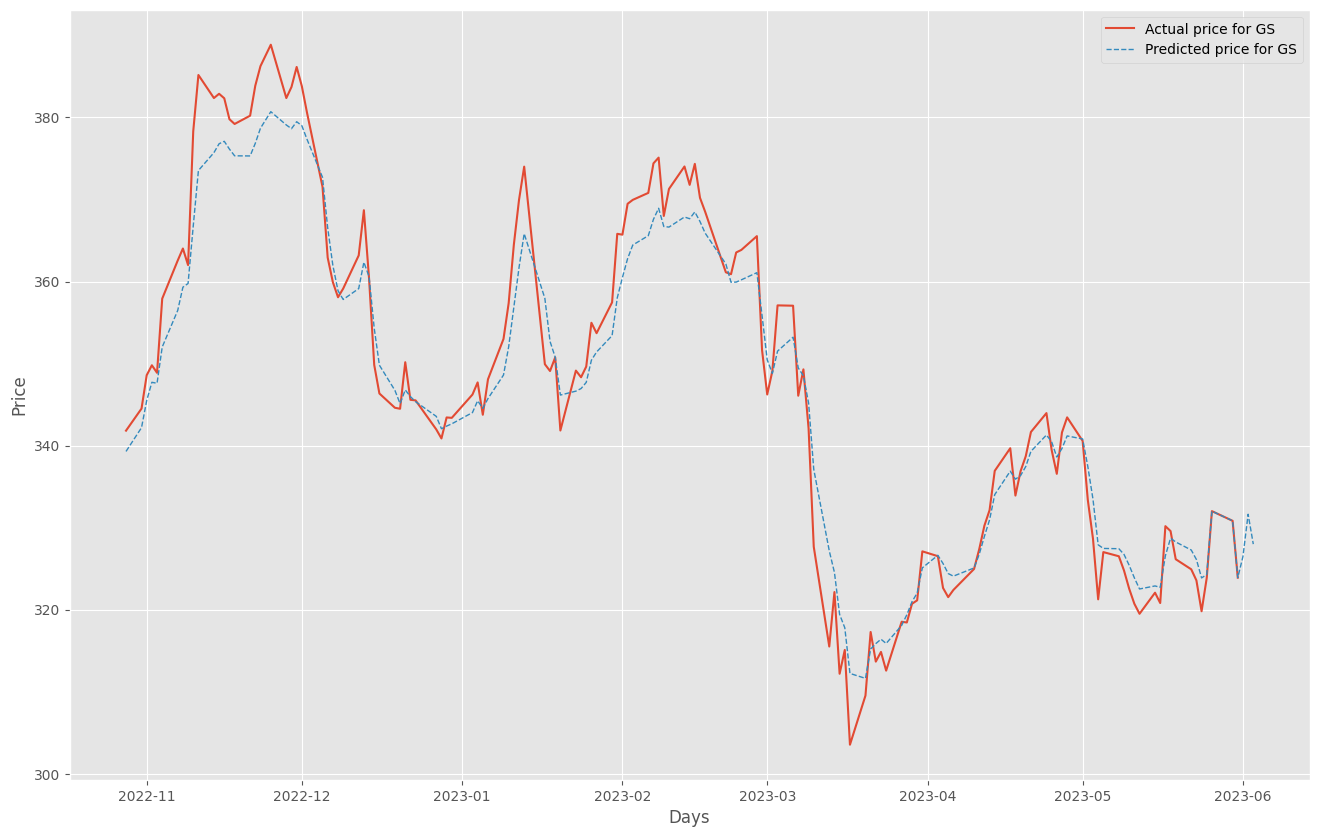

In [ ]:
# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(merged_df['close_y'][-150:].head(147))
plt.plot(merged_df['predicted_close'][-150:].head(150), linewidth=1, linestyle='dashed')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend([f'Actual price for {STOCK}', 
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()